In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os 
import sklearn
from data_preperation import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
data_original = pd.read_csv('ElectionsData.csv', header=0)
data_original.head()

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Last_school_grades,Most_Important_Issue,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Financial_agenda_matters,Num_of_kids_born_last_10_years,Overall_happiness_score
0,Violets,1.0,113.445801,1688.510190,Below_30,1477.809692,Yes,202.042787,Yes,Male,...,60.0,Financial,12.0,683.760440,1.0,Public_or_other,Industry_or_other,No,1.0,392.803101
1,Browns,2.0,161.720841,696.069582,Below_30,2969.865888,Yes,88.942300,Yes,Male,...,60.0,Financial,9.0,793.017823,2.0,Car,Industry_or_other,No,0.0,41.028616
2,Greens,6.0,524.947117,50048.853880,30-45,30803.812970,No,789.796962,Yes,Female,...,80.0,Healthcare,10.0,253.102383,1.0,Motorcycle_or_truck,Services_or_Retail,No,0.0,635.000942
3,Whites,1.0,521.454363,50265.185360,Below_30,30396.557250,No,565.727946,Yes,Male,...,NaN,Social,8.0,278.904297,1.0,Car,Services_or_Retail,No,0.0,502.278182
4,Browns,6.0,210.879361,7793.195795,30-45,5021.415879,No,423.589896,Yes,Female,...,70.0,Social,11.0,605.564038,4.0,Car,Public_Sector,No,2.0,40.469037


In [30]:
discrete_features = ['Occupation_Satisfaction', 'Last_school_grades', 'Number_of_differnt_parties_voted_for', 'Number_of_valued_Kneset_members', 'Num_of_kids_born_last_10_years']
continuous_features = ['Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
                      'Financial_balance_score_(0-1)', '%Of_Household_Income', 'Yearly_IncomeK', 'Avg_size_per_room', 'Garden_sqr_meter_per_person_in_residancy_area', 'Avg_Residancy_Altitude',
                      'Yearly_ExpensesK', '%Time_invested_in_work', 'Avg_education_importance', 'Avg_Satisfaction_with_previous_vote', 
                      'Avg_monthly_household_cost', 'Phone_minutes_10_years', 'Avg_government_satisfaction', 'Weighted_education_rank', '%_satisfaction_financial_policy',
                      'Avg_monthly_income_all_years', 'Political_interest_Total_Score', 'Overall_happiness_score']
nominal_features = ['Vote', 'Will_vote_only_large_party', 'Age_group', 'Voting_Time']
onehot_nominal_features = ['Most_Important_Issue', 'Main_transportation', 'Occupation']
binary_features = ['Gender', 'Looking_at_poles_results', 'Married', 'Financial_agenda_matters']

numerical_features = discrete_features + continuous_features
total_nominal_features = nominal_features + onehot_nominal_features + binary_features

In [31]:
uniform_features = ['Occupation_Satisfaction', 'Financial_balance_score_(0-1)',
                    '%Of_Household_Income', 'Yearly_IncomeK', 'Avg_government_satisfaction',
                    '%_satisfaction_financial_policy', 'Garden_sqr_meter_per_person_in_residancy_area',
                    'Yearly_ExpensesK', '%Time_invested_in_work']
normal_features = ['Number_of_differnt_parties_voted_for', 'Number_of_valued_Kneset_members',
                   'Avg_environmental_importance',
                   'Avg_education_importance', 'Avg_monthly_household_cost', 'Weighted_education_rank',
                   'Overall_happiness_score', 'Avg_size_per_room', 'Avg_Residancy_Altitude']
unknown_features = ['Last_school_grades', 'Num_of_kids_born_last_10_years',
                    'Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses',
                    'Avg_monthly_expense_on_pets_or_plants', 'Avg_Satisfaction_with_previous_vote',
                    'Phone_minutes_10_years', 'Avg_monthly_income_all_years', 'Political_interest_Total_Score']


In [32]:
data = data_original.copy()



In [33]:
data = convert_to_onehot(data, onehot_nominal_features)
data

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Social,Car,Foot_or_bicycle,Motorcycle_or_truck,Public_or_other,Hightech,Industry_or_other,Public_Sector,Services_or_Retail,Student_or_Unemployed
0,Violets,1.0,113.445801,1688.510190,Below_30,1477.809692,Yes,202.042787,Yes,Male,...,0,0,0,0,1,0,1,0,0,0
1,Browns,2.0,161.720841,696.069582,Below_30,2969.865888,Yes,88.942300,Yes,Male,...,0,1,0,0,0,0,1,0,0,0
2,Greens,6.0,524.947117,50048.853880,30-45,30803.812970,No,789.796962,Yes,Female,...,0,0,0,1,0,0,0,0,1,0
3,Whites,1.0,521.454363,50265.185360,Below_30,30396.557250,No,565.727946,Yes,Male,...,1,1,0,0,0,0,0,0,1,0
4,Browns,6.0,210.879361,7793.195795,30-45,5021.415879,No,423.589896,Yes,Female,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Purples,9.0,124.023053,26638.227290,30-45,1760.420762,No,1060.517225,No,Female,...,0,0,0,1,0,0,0,1,0,0
9996,Blues,1.0,1146.385393,245768.367300,30-45,146414.291700,No,826.909059,No,Female,...,0,0,0,0,1,1,0,0,0,0
9997,Turquoises,7.0,173.952313,20598.709440,45_and_up,3430.140470,No,690.466486,Yes,Female,...,0,0,1,0,0,0,1,0,0,0
9998,Oranges,10.0,307.277614,41875.937280,45_and_up,10603.484990,No,547.345514,Yes,Female,...,0,0,0,1,0,0,1,0,0,0


In [34]:
data = convert_to_categorical(data)
data

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Social,Car,Foot_or_bicycle,Motorcycle_or_truck,Public_or_other,Hightech,Industry_or_other,Public_Sector,Services_or_Retail,Student_or_Unemployed
0,10,1.0,113.445801,1688.510190,2,1477.809692,1,202.042787,1,1,...,0,0,0,0,1,0,1,0,0,0
1,1,2.0,161.720841,696.069582,2,2969.865888,1,88.942300,1,1,...,0,1,0,0,0,0,1,0,0,0
2,2,6.0,524.947117,50048.853880,0,30803.812970,0,789.796962,1,0,...,0,0,0,1,0,0,0,0,1,0
3,11,1.0,521.454363,50265.185360,2,30396.557250,0,565.727946,1,1,...,1,1,0,0,0,0,0,0,1,0
4,1,6.0,210.879361,7793.195795,0,5021.415879,0,423.589896,1,0,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,9.0,124.023053,26638.227290,0,1760.420762,0,1060.517225,0,0,...,0,0,0,1,0,0,0,1,0,0
9996,0,1.0,1146.385393,245768.367300,0,146414.291700,0,826.909059,0,0,...,0,0,0,0,1,1,0,0,0,0
9997,9,7.0,173.952313,20598.709440,1,3430.140470,0,690.466486,1,0,...,0,0,1,0,0,0,1,0,0,0
9998,5,10.0,307.277614,41875.937280,1,10603.484990,0,547.345514,1,0,...,0,0,0,1,0,0,1,0,0,0


In [49]:
# Split
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, test_size=0.15, val_size=0.15)

In [50]:
XY_train = insert_label_to_data(X_train, y_train)


print(f'Number of negative values: {(XY_train.dropna().values < 0).sum()}')
XY_train = remove_negative(XY_train) # TODO check if removing is good or maybe abs
print(f'Number of negative values: {(XY_train.dropna().values < 0).sum()}')

print(f'Number of nan before: {XY_train.isnull().values.sum()}')
outlier = Outlier(XY_train)
XY_train = outlier.remove_outlier(XY_train, 3)
print(f'Number of nan after: {XY_train.isnull().values.sum()}')


Number of negative values: 183
Number of negative values: 0
Number of nan before: 4306
Number of nan after: 4636


In [51]:

print(f'Number of nan before: {XY_train.isnull().values.sum()}')
imputation = Imputation(XY_train)
XY_train = imputation.impute_train(XY_train)
print(f'Number of nan after: {XY_train.isnull().values.sum()}')        


Number of nan before: 4636
Number of nan after: 0


In [52]:
print(f'Number of nan before: {X_test.isnull().values.sum() + X_val.isnull().values.sum()}')
X_test, X_val = imputation.impute_test_val(X_test, X_val)
print(f'Number of nan after: {X_test.isnull().values.sum() + X_val.isnull().values.sum()}')  

Number of nan before: 1697
Number of nan after: 0


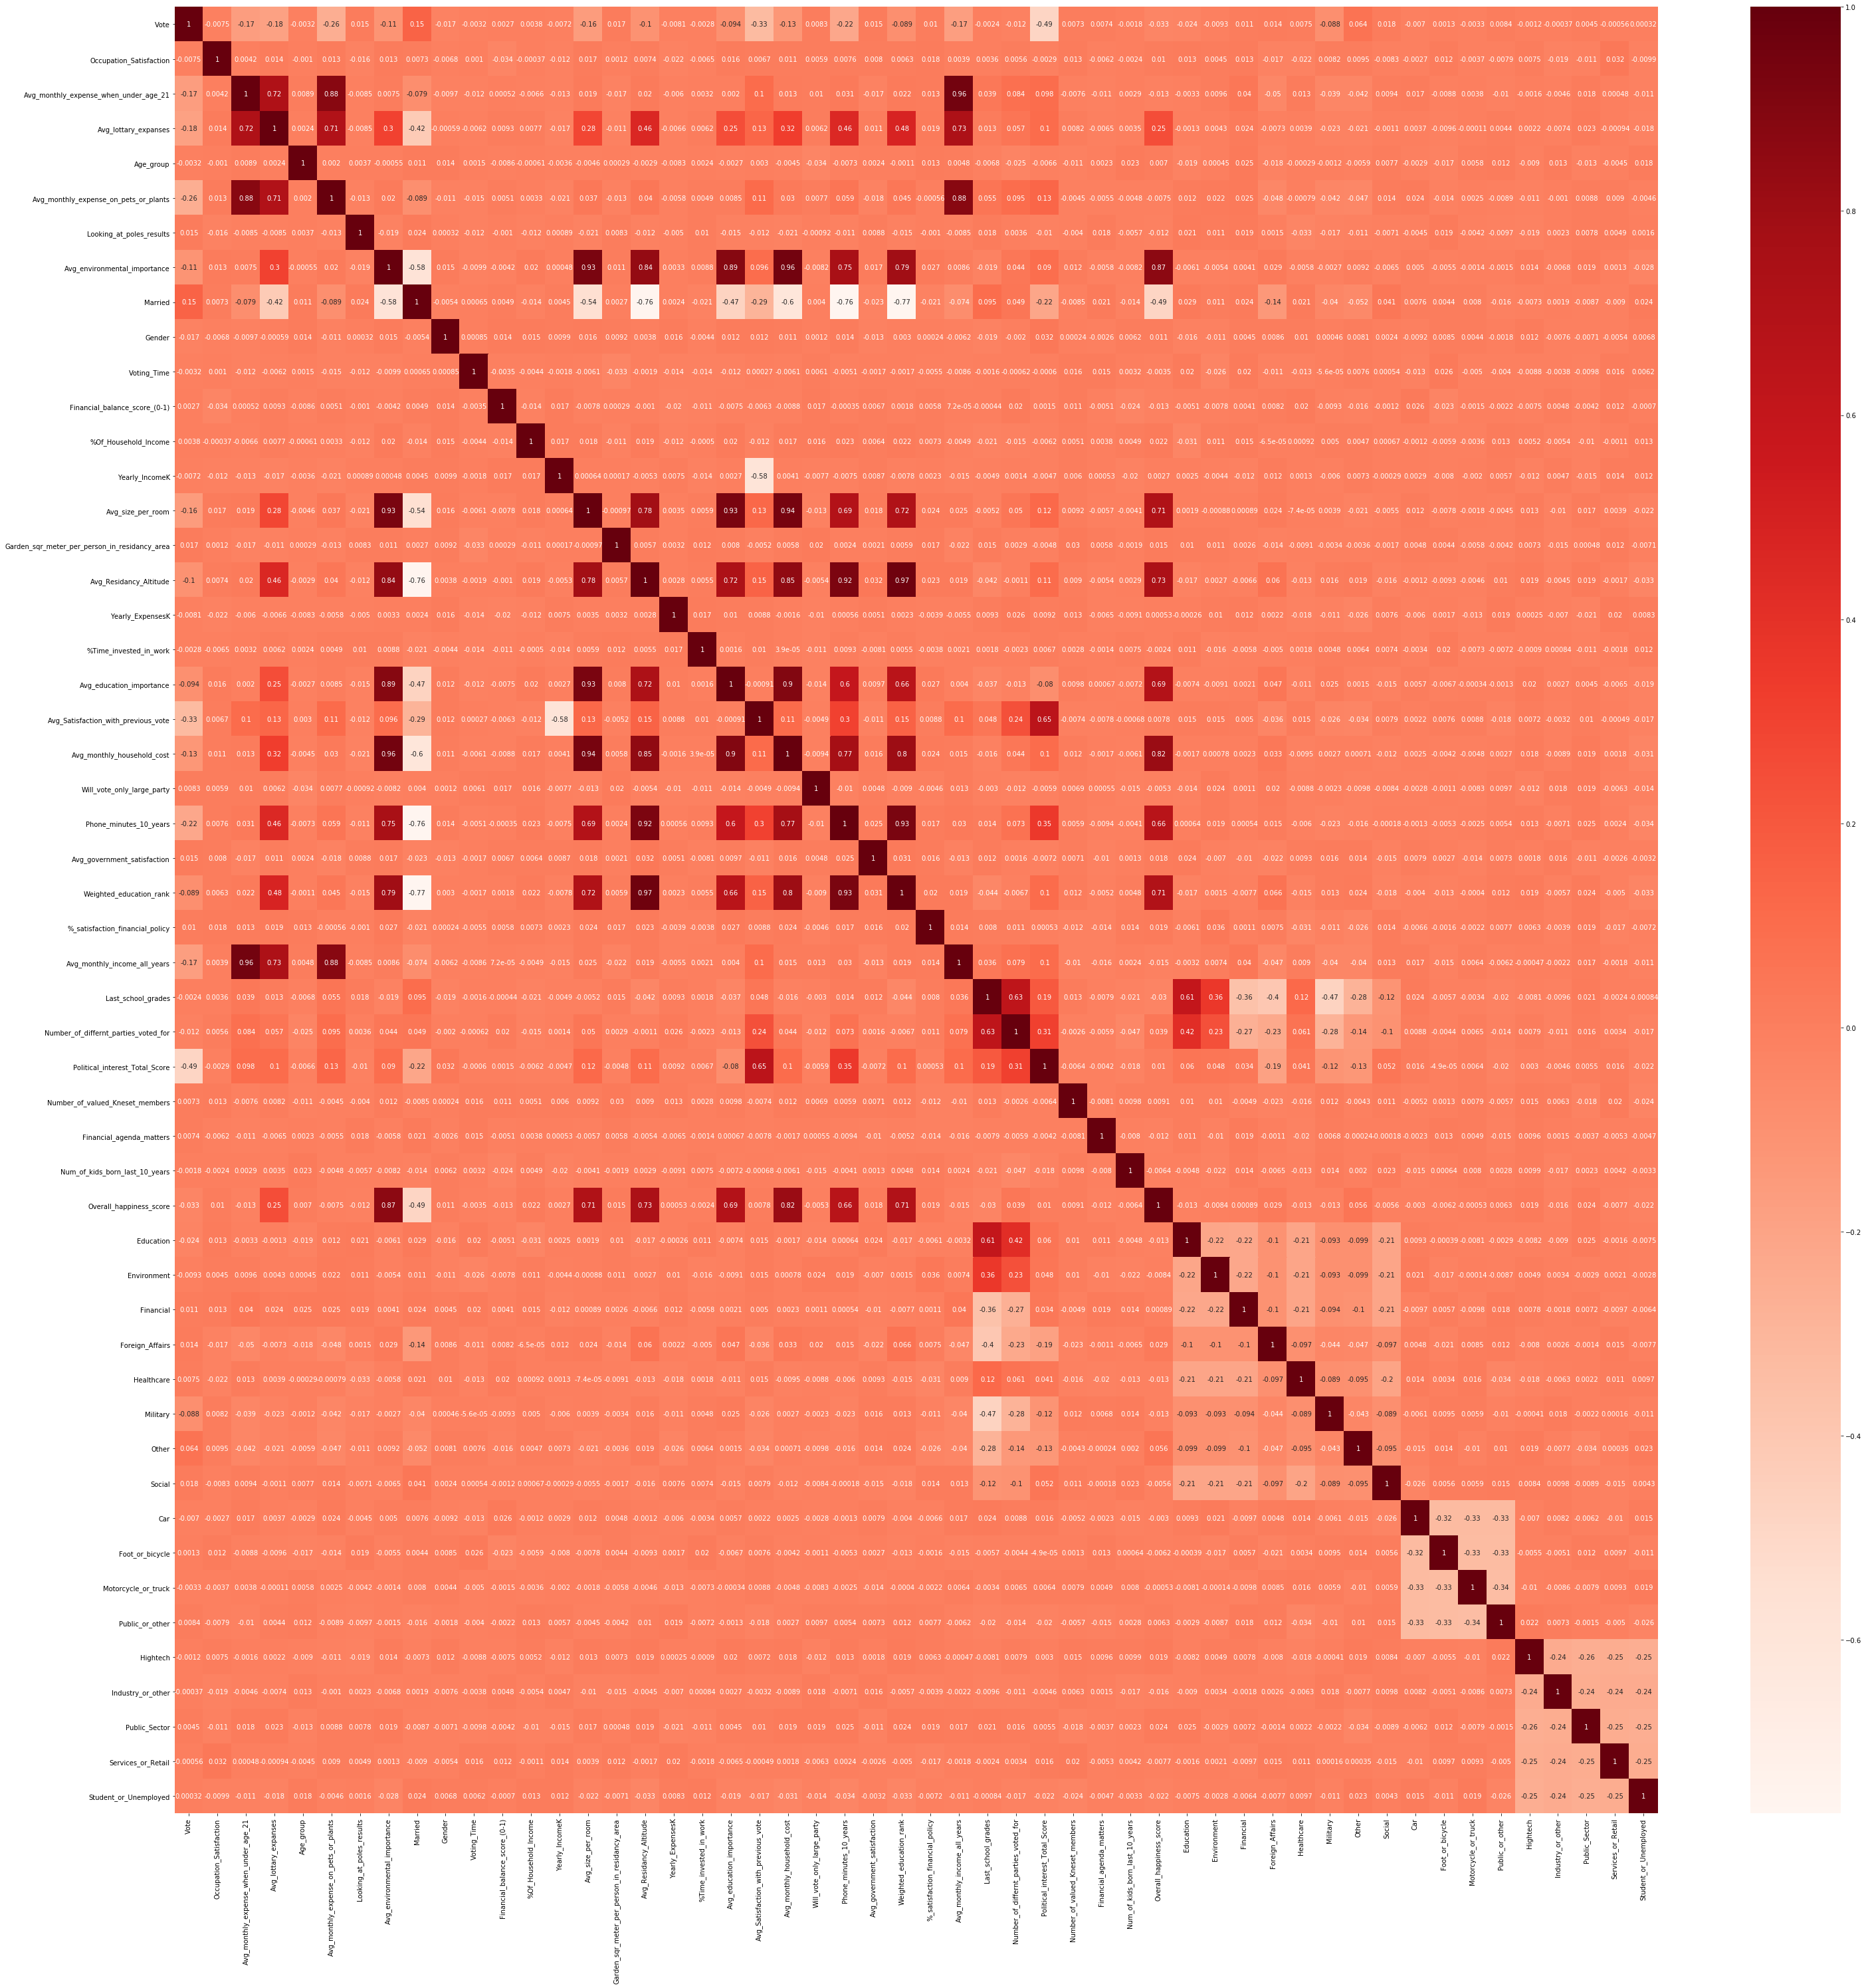

In [13]:
# using pearson correlation to find correlation between all features (this finds only linear relations)
import seaborn as sns
plt.figure(figsize=(50, 50))
cor = XY_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [14]:
cor = cor[abs(cor)>0.2]
cor.to_csv('correlation_matrix.csv')

In [65]:
from test import test_accuracy
X_train, y_train = split_label_from_data(XY_train)
print(test_accuracy(X_train, y_train, X_test, y_test))

{'svm': 0.23933333333333334, 'forest': 0.9106666666666666, 'knn': 0.77, 'perceptron': 0.19733333333333333, 'bn': 0.7913333333333333}


In [64]:
#Test for SFS algorithem
from feature_selection import SFS
from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators = 3)

selected_features = SFS(forest, X_train,y_train,X_test,y_test) 
selected_features

[15]
[15, 13]
[15, 13, 33]
[15, 13, 33, 27]
[15, 13, 33, 27, 26]
[15, 13, 33, 27, 26, 28]
[15, 13, 33, 27, 26, 28]


['Avg_size_per_room',
 'Avg_Residancy_Altitude',
 'Avg_monthly_income_all_years',
 'Last_school_grades',
 'Number_of_differnt_parties_voted_for',
 'Overall_happiness_score']